# NLP Final Project - Feature Engineering & Modeling

# Summary

Here we engineer features and conduct predictive modeling to classify text as fake news or not fake news.

### Text classification problem: fake news vs not fake news

**Vectorizing Text Data**
- TF-IDF vectorizer
    - max_df = 0.9
    - min_df = 2
    - lowercase
    - stop_words
    - max_features = 20,000
    - ngram_range = (1,2)

**Dimensionality Reduction: topic distribution matrix**
- NMF
    - n_components = 100

**ML Models**
- Binary Classification
    - Logistic Regression
        - threshold value for predicting classes
        - logistic regression with l1 penalty can be used for feature selection
        - C: regularization parameter (strength of regularization is inversely proportional to C); must be positive
    - Linear SVC (better than regular SVC for large sample sizes)
        - l1 penalty can be used for feature selection
        - C: regularization parameter (strength of regularization is inversely proportional to C); must be positive
    - Random Forest
        - n_estimators: # trees in forest
        - max_depth: maximum depth (splits) of the tree
- One-Class Classification & Outlier Detection
    - Isolation Forest
        - n_estimators: # trees in forest
        - max_features: # of features to draw to train base estimators (default = 1)
    - One-Class SVM

# Import Modules & Data

In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.help import upenn_tagset
from nltk import word_tokenize, pos_tag
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import NMF, PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.svm import LinearSVC, OneClassSVM
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectKBest
from sklearn.metrics import classification_report
import umap
from imblearn.under_sampling import RandomUnderSampler
# import other modules...

In [2]:
articles = pd.read_csv('./articles_100K_plusSentiment.csv', index_col = 0)
articles.head()

,news_source,pub_date,title,text,fake_news_binary,left_bias_avg,right_bias_avg,net_bias,fake_news_outlier,clean_txt,PoS_tags,pos_sent,neg_sent,net_sent
0,The Sun,2018-10-17,Who left Big Brother last week and whos still ...,THE last ever Big Brother is underway with a f...,0,0.00,1.0,1.00,1,last ever Big Brother be underway final batch ...,DT JJ RB JJ NN VBZ RB IN DT JJ NN IN NNS . IN ...,0.062016,0.093023,-0.031008
1,True Pundit,2018-02-08,I Have to Let Them in DHS Chief Reveals How MS...,During a White House roundtable discussion on ...,1,0.00,1.0,1.00,-1,White House roundtable discussion immigration ...,"IN DT NNP NNP JJ NN IN NN CC NN NN , DT NN IN ...",0.118483,0.113744,0.004739
2,The Daily Caller,2018-11-16,Trump Works On Mueller Answers Avoiding Perjur...,President Donald Trump is working on written a...,0,0.00,1.0,1.00,1,President Donald Trump be work write answer qu...,NNP NNP NN VBZ VBG IN VBN NNS TO NNS IN JJ NN ...,0.061644,0.068493,-0.006849
3,The Daily Caller,2018-08-28,McConnell Announces Bipartisan Senate Group Wi...,Senate Majority Leader Mitch McConnell announc...,0,0.00,1.0,1.00,1,Senate Majority Leader Mitch McConnell announc...,NNP NN NN NN NNP VBD DT NN NNP NN MD VB VBG RB...,0.133333,0.033333,0.100000
4,BBC,2018-07-23,Why millions listen to this nine-year-old girl...,A scheme to let parents close their streets to...,0,0.25,0.0,-0.25,1,scheme let parent close street car so child ca...,DT NN TO VB NNS RB PRP$ NNS TO NNS RB NNS MD N...,0.050000,0.250000,-0.200000


In [3]:
len(articles)

100000

In [4]:
articles['fake_news_binary'].value_counts()

0    75072
1    24928
Name: fake_news_binary, dtype: int64

# Split - Train & Test

In [5]:
text_train, text_test, y_train, y_test = train_test_split(articles[['clean_txt', 'PoS_tags', 'text', 'net_sent']],
                                                          articles[['fake_news_binary', 'fake_news_outlier']],
                                                          stratify = articles['fake_news_binary'],
                                                          random_state = 64,
                                                          train_size = 0.85)

# Specify Y vectors for binary classification & outlier detection

In [6]:
# to make y vector one-dimensional numpy array
#
# y_bi_ for binary classification ("reliable" = 0, "unreliable" = 1)
y_bi_train = y_train[['fake_news_binary']].to_numpy().ravel()
y_bi_test = y_test[['fake_news_binary']].to_numpy().ravel()
#
# y_out_ for outlier detection ("reliable"/inler = 1, "unreliable"/outlier = -1)
y_out_train = y_train[['fake_news_outlier']].to_numpy().ravel()
y_out_test = y_test[['fake_news_outlier']].to_numpy().ravel()

# Create Punctuation Vectorizer Class

This will be used to transform the original (uncleaned) text into a BoW matrix for a selected set of punctuation symbols which we believe may be useful in distinguishing between articles with regard to our targets.

In [7]:
# creating CV matrix for punctuation(!?:;)
class Punc_Vec:
    def __init__(self,
                 analyzer = 'char',
                 binary = False,
                 decode_error = 'strict',
                 dtype = np.int64,
                 encoding = 'utf-8',
                 input = 'content',
                 lowercase = False,
                 max_df = 1.0,
                 min_df = 1,
                 ngram_range = (1,1),
                 max_features = None,
                 strip_accents = None,
                 preprocessor = None,
                 tokenizer = None,
                 stop_words = None,
                 vocabulary = None,
                 token_pattern = '(?u)\b\w\w+\b'):
        self.analyzer = analyzer
        self.binary = binary
        self.decode_error = decode_error
        self.dtype = dtype
        self.encoding = encoding
        self.input = input
        self.lowercase = lowercase
        self.max_df = max_df
        self.min_df = min_df
        self.ngram_range = ngram_range
        self.max_features = max_features
        self.strip_accents = strip_accents
        self.preprocessor = preprocessor
        self.tokenizer = tokenizer
        self.stop_words = stop_words
        self.vocabulary = vocabulary
        self.token_pattern = token_pattern
        self.c = None
        self.v = CountVectorizer(analyzer = self.analyzer,
                                 binary = self.binary,
                                 decode_error = self.decode_error,
                                 dtype = self.dtype,
                                 encoding = self.encoding,
                                 input = self.input,
                                 lowercase = self.lowercase,
                                 max_df = self.max_df,
                                 min_df = self.min_df,
                                 ngram_range = self.ngram_range,
                                 max_features = self.max_features,
                                 strip_accents = self.strip_accents,
                                 preprocessor = self.preprocessor,
                                 tokenizer = self.tokenizer,
                                 stop_words = self.stop_words,
                                 vocabulary = self.vocabulary,
                                 token_pattern = self.token_pattern)
        self.params = None
        self.f = None
        self.t = None
        self.f_t = None
        self.g = None
    def get_params(self, deep = True):
        self.params = self.v.get_params(deep)
        return(self.params)
    def fit(self, corpus, y = None):
        self.c = corpus.tolist()
        punc_only = []
        for i in range(len(self.c)):
            punc_only.append([])
            punc_only[i] = re.sub(r"[^!?:;]", "", self.c[i])
        self.f = self.v.fit(punc_only)
    def transform(self, corpus):
        self.t = self.v.transform(corpus.tolist())
        return(self.t)
    def fit_transform(self, corpus, y = None):
        self.c = corpus.tolist()
        punc_only = []
        for i in range(len(self.c)):
            punc_only.append([])
            punc_only[i] = re.sub(r"[^!?:;]", "", self.c[i])
        self.f_t = self.v.fit_transform(punc_only)
        return self.f_t
    def get_features(self):
        self.g = self.v.get_feature_names()
        return(self.g)

In [8]:
sample_corpus = articles['text'][:15]

punctuation_vectorizer = Punc_Vec()
punctuation_vectorizer.fit_transform(sample_corpus).toarray()

array([[ 0,  0,  0,  0],
       [ 0,  1,  1,  0],
       [ 0,  0,  0,  0],
       [ 0,  1,  0,  0],
       [ 0,  0,  0,  0],
       [ 1,  0,  0,  5],
       [ 0,  0,  0,  0],
       [ 0,  4,  0,  0],
       [ 0,  0,  0,  0],
       [ 0,  6,  0,  1],
       [ 0,  1,  0,  0],
       [ 0,  0,  0,  0],
       [ 0,  0,  0,  0],
       [ 0,  0,  0,  0],
       [ 1, 20,  4,  6]])

In [9]:
punctuation_vectorizer.get_features()

['!', ':', ';', '?']

# Feature engineering

From the text, clean text, and PoS tag columns, we need to obtain the following:
- BoW matrix of punctuation from original (uncleaned) text
- topic distribution matrix & K best term vectors from the BoW matrix
- BoW matrix from PoS tags column = count-vectorized PoS tags

We also need to pull the net sentiment score column and append to these resulting matrices.

In [13]:
# need to use ColumnTransformer() to do different things to 'text', 'clean_txt', and 'PoS_tags' columns;
# need to use FeatureUnion() to simultaneously perform dimensionality reduction and feature selection
# on the 'clean_txt' column

# Set up feature union to do both dimensionality reduction (compare NMF & LSA) and select
# K best performing word vectors; in other words, get topics & keep important words.

# set number of topics
topics = 100

# set number of words from BoW to keep in model
top_terms = 20

nmf = NMF(n_components = topics, random_state = 42)
kbest = SelectKBest(k = top_terms)

featUn = FeatureUnion([
    ('dim_red', nmf),
    ('feat_sel', kbest)
])

# Set up pipeline for clean text: vectorize followed by simultaneous dimensionality
# reduction and feature selection.
tfidf = TfidfVectorizer(stop_words = 'english',
                        ngram_range = (1,2),
                        max_df = 0.90,
                        min_df = 2,
                        max_features = 20000)

cleanTextPipe = Pipeline([
    ('vectorize', tfidf),
    ('dimRed_plus_featSel', featUn)
])

# Set up column transformer to distinguish between vectorizing clean text and original text.
#
# For clean text, perform the following: TF-IDF vectorize; then perform dimensionality
# reduction (NMF) & feature selection (SelectKBest).
#
# For PoS text, perform the following: vectorize PoS tags (CountVectorizer).
countvec = CountVectorizer(lowercase = False)
#
# For original text, perform the following: vectorize select punctuation (CountVectorizer).
puncvec = Punc_Vec()

sep_cols = ColumnTransformer(
    # transformers
    [
        ('vectorize_punctuation', puncvec, 'text'), # perform only on text column
        ('clean_text_pipe', cleanTextPipe, 'clean_txt'), # perform only on clean_txt column
        ('vectorize_PoS', countvec, 'PoS_tags') # perform only on PoS_tags column
    ],
    # keep the 'net_sent' column with no transformations
    remainder = 'passthrough'
)

In [14]:
# Fit & transform the X_train dataframe into the feature matrix for training models
X_train = sep_cols.fit(text_train, y_bi_train)

In [15]:
import joblib
joblib.dump(sep_cols, 'column_transformer.joblib')

['column_transformer.joblib']

In [12]:
# Transform the X_test dataframe into the feature matrix for testing models
X_test = sep_cols.transform(text_test)

In [13]:
# Use random undersampling of majority class ("reliable" news) to improve model training
X_train_resample, y_bi_train_resample = RandomUnderSampler('majority').fit_resample(X_train, y_bi_train)

In [14]:
X_train_resample

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         2.        , -0.01287554],
       [ 0.        ,  5.        ,  1.        , ...,  4.        ,
         2.        ,  0.04896422],
       [ 3.        ,  1.        ,  0.        , ...,  2.        ,
         1.        , -0.04651163],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        , -0.10526316],
       [ 0.        ,  0.        ,  0.        , ...,  1.        ,
         1.        , -0.01515152],
       [ 4.        ,  1.        ,  0.        , ...,  9.        ,
         7.        , -0.03351955]])

In [15]:
y_bi_train_resample

array([0, 0, 0, ..., 1, 1, 1])

### Inspect Topics

In [16]:
# define function to retrieve top n words from k topics
def top_words(model, features, n):
    for i, topic in enumerate(model.components_):
        message = 'Topic ' + str(i+1) + ': '
        topic_words = []
        for j in topic.argsort()[-n:][::-1]:
            topic_words.append(features[j])
        print(message + str(', '.join(topic_words)))

In [17]:
n = 10 # number of words per topic

tfidf_vectorizer = TfidfVectorizer(stop_words = 'english',
                                   ngram_range = (1,2),
                                   max_df = 0.90,
                                   min_df = 2,
                                   max_features = 20000)
X_textTFIDF = tfidf_vectorizer.fit_transform(text_train['clean_txt'])

features = tfidf_vectorizer.get_feature_names()
nmf_model = NMF(n_components = topics, random_state = 42).fit(X_textTFIDF)

print('NMF Tf-idf Topics')
top_words(nmf_model, features, n)

NMF Tf-idf Topics
Topic 1: say, told, add, statement, ask, comment, trump say, interview, want, monday
Topic 2: nginx, forbidden nginx, forbidden, ban, asylum, guard, chinese, rule, apparently, potter
Topic 3: trump, donald, donald trump, trump say, trumps, tweet, president donald, administration, campaign, say trump
Topic 4: putin, vladimir, vladimir putin, meeting, russian president, president vladimir, russian, russia, summit, helsinki
Topic 5: der, die, und, den, von, zu, mit, da, das, auf
Topic 6: league, premier league, premier, season, chelsea, arsenal, liverpool, club, goal, manchester
Topic 7: democrats, republicans, seat, house, midterm, senate, republican, election, gop, democratic
Topic 8: russian, russia, moscow, sanction, skripal, foreign, ukraine, ministry, ukrainian, russias
Topic 9: north, korea, kim, north korea, korean, north korean, summit, nuclear, south, south korea
Topic 10: brexit, eu, deal, uk, britain, theresa, european, mrs, ireland, referendum
Topic 11: spac

### Inspect K "Best Terms"

In [18]:
kbest_model = SelectKBest(k = top_terms)
kbest_transformed = kbest_model.fit_transform(X_textTFIDF, y_bi_train)
kbest_transformed.toarray().shape
# indices of features (terms) selected from BoW matrix
kbest_model.get_support(indices = True)

array([  204,   219,  1016,  3202,  4930,  5229,  6715,  8879,  9510,
       11342, 12765, 13815, 13817, 14028, 15592, 16422, 16543, 17853,
       18305, 19827])

In [19]:
# map indices to words
kbest_indices = kbest_model.get_support(indices = True)

# print out terms matching indices
for el in kbest_indices:
    print(tfidf_vectorizer.get_feature_names()[el])

according
accuracy journalism
article post
commit truth
donald
editorial standard
game
journalism read
league
necessarily reflect
play
read
read editorial
reflect sputnik
season
speaker necessarily
sputnik
told sputnik
truth accuracy
year


### Inspect PoS Tags

In [20]:
countvec = CountVectorizer(lowercase = False)
PoS_counts = countvec.fit_transform(text_train['PoS_tags'])
countvec.get_feature_names()

['CC',
 'CD',
 'DT',
 'EX',
 'FW',
 'IN',
 'JJ',
 'JJR',
 'JJS',
 'LS',
 'MD',
 'NN',
 'NNP',
 'NNPS',
 'NNS',
 'PRP',
 'RB',
 'RBR',
 'RBS',
 'SYM',
 'TO',
 'UH',
 'VB',
 'VBD',
 'VBG',
 'VBN',
 'VBP',
 'VBZ',
 'WDT',
 'WP',
 'WRB']

### Inspect Punctuation Features

In [21]:
puncvec = Punc_Vec()

# fit to text column & transform
puncvec.fit_transform(text_train['text'])

# see list of punctuation features
punctuation_features = puncvec.get_features()
punctuation_features

['!', ':', ';', '?']

# Train & Evaluate Models

## Create New Logistic Regression Class

Scikit-learn's implementation of logistic regression does not include probability threshold as a hyperparameter. We will create our own logistic regression class which does include probability threshold as a hyperparameter.

To incorporate in the below pipeline, our logistic regression class will need to have fit, predict, and set_params methods.

In [22]:
class myLogisticRegression:
    # initialize class and private variables
    def __init__(self,
                 prob_threshold = 0.5, # key difference: include tuneable hyperparameter for probability threshold
                 penalty = 'l1', # different from sklearn's implementation; want to do LASSO by default
                 C = 1.0, # same as sklearn's implementation
                 tol = 0.0001, # same as sklearn's implementation
                 fit_intercept = False, # different from sklearn's implementation; don't want to fit intercept
                 class_weight = None, # same as sklearn's implementation
                 solver = 'saga' # different from sklearn's implementation; can do l1 & l2 penalties, and good
                 # for large size datasets
                ):
        
        self.prob_thresh = prob_threshold
        self.penalty = penalty
        self.C = C
        self.tol = tol
        self.fit_intercept = fit_intercept
        self.class_weight = class_weight
        self.solver = solver
        #self.logit = None
        self.coef = None
        self.classes = None
        self.intercept = None
        self.params = {
            'prob_threshold': self.prob_thresh,
            'penalty': self.penalty,
            'C': self.C,
            'tol': self.tol,
            'fit_intercept': self.fit_intercept,
            'class_weight': self.class_weight,
            'solver': self.solver
        }
        self.logit = LogisticRegression(penalty = self.params['penalty'],
                                         tol = self.params['tol'],
                                         C = self.params['C'],
                                         fit_intercept = self.params['fit_intercept'],
                                         class_weight = self.params['class_weight'],
                                         solver = self.params['solver']
                                        )
        self.logit_params = self.logit.get_params()
        
    # return self.string when class is instantiated
    # idea to use '__repr__' method taken from this thread:
    # https://stackoverflow.com/questions/12412324/python-class-returning-value/37802740
    def __repr__(self):
        return 'myLogisticRegression()'
        
    def fit(self, X_train, y_train, sample_weight = None):
        # in case I change the parameters with the set_params method, re-instantiate logistic regression
        #self.logit = LogisticRegression(penalty = self.params['penalty'],
                                         #tol = self.params['tol'],
                                         #C = self.params['C'],
                                         #fit_intercept = self.params['fit_intercept'],
                                         #class_weight = self.params['class_weight'],
                                         #solver = self.params['solver'])
        self.logit_params = self.logit.get_params()
        logit_model = self.logit.fit(X_train, y_train, sample_weight)
        self.coef = self.logit.coef_
        self.classes = self.logit.classes_
        self.intercept = self.logit.intercept_
        
        return logit_model
    
    def predict(self, X_test):
        prob_predictions = self.logit.predict_proba(X_test)[:,1] # pull out probability predictions for class 1
        y_pred = []
        for el in prob_predictions:
            if el >= self.prob_thresh: # if the predicted probability is at least equal to my threshold...
                y_pred.append(1) # predict class 1 (fake news)
            else:
                y_pred.append(0) # else, predict class 0 (not fake news)
        
        return np.asarray(y_pred)
    
    def set_params(self, **params):
        #self.logit.set_params(**params)
        #change_params = params
        for el in params:
            if el in self.params:
                self.params[el] = params[el]
        
        self.logit = LogisticRegression(penalty = self.params['penalty'],
                                         tol = self.params['tol'],
                                         C = self.params['C'],
                                         fit_intercept = self.params['fit_intercept'],
                                         class_weight = self.params['class_weight'],
                                         solver = self.params['solver']
                                       )
        
        return self.logit

## Pipeline

In [23]:
# Set up pipeline steps
scaler = StandardScaler(with_mean = False)

steps = [
    ('scale', scaler),
    ('classify', 'passthrough')
]
# Instantiate pipeline
pipe = Pipeline(steps)

## GridSearchCV for Binary Classification Models

In [25]:
# Set up classification hyperparameter values to test:
prob_thresholds = [0.25, 0.5, 0.75]
c = [0.001, 0.01, 0.1, 1]
trees = [50, 100, 500]
d = [50, 100, 150]
#
# Stratified CV (to make sure there is the same class distribution in all folds):
cv = StratifiedKFold(n_splits = 5)
#
# Instantiate classification classes
logistic = myLogisticRegression()
svc = LinearSVC(dual = False, penalty = 'l1')
randomforest = RandomForestClassifier()

params = [
    # for logistic regression classifier
    {
        'classify': [logistic],
        'classify__C': c,
        'classify__prob_threshold': prob_thresholds
    },
    # for linear SVC classifier
    {
        'classify': [svc],
        'classify__C': c
    },
    # for the random forest classifier
    {
        'classify': [randomforest],
        'classify__n_estimators': trees,
        'classify__max_depth': d
    }
]

grid = GridSearchCV(pipe, params, cv = cv, scoring = ['accuracy', 'f1'], refit = 'accuracy')
grid.fit(X_train_resample, y_bi_train_resample)

/Users/caitlinmoroney/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/caitlinmoroney/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/caitlinmoroney/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/caitlinmoroney/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/caitlinmoroney/opt/anaconda3/lib/python3.7/site-packages/

/Users/caitlinmoroney/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/caitlinmoroney/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/caitlinmoroney/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/caitlinmoroney/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/caitlinmoroney/opt/anaconda3/lib/python3.7/site-packages/

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('scale',
                                        StandardScaler(copy=True,
                                                       with_mean=False,
                                                       with_std=True)),
                                       ('classify', 'passthrough')],
                                verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid=[{'classify': [myLogisticRegression()],
                          'classify__C': [0.001, 0.01, 0.1, 1],...
                                                              min_impurity_split=None,
                                                              min_samples_leaf=1,
                                                              min_samples_split=2,
                                           

In [26]:
# best estimator + hyperparameters
grid.best_params_

{'classify': RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                        criterion='gini', max_depth=100, max_features='auto',
                        max_leaf_nodes=None, max_samples=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=2,
                        min_weight_fraction_leaf=0.0, n_estimators=500,
                        n_jobs=None, oob_score=False, random_state=None,
                        verbose=0, warm_start=False),
 'classify__max_depth': 100,
 'classify__n_estimators': 500}

In [27]:
# print out variables + coefficients

# feature vectors:
# - first 100 vectors: 100 topics
# - next 20: 20 K best vectors from BoW matrix
# - all remaining columns: PoS tags BoW matrix
topic_names = ['Topic ' + str(i+1) for i in range(topics)]
bestKterms = [tfidf_vectorizer.get_feature_names()[el] for el in kbest_indices]
# list of all features mapped to correct indices
all_feature_names = punctuation_features + topic_names + bestKterms + countvec.get_feature_names() + ['net_sentiment']

# only relevant if best estimator is random forest
if 'RandomForest' in str(grid.best_estimator_):
    importances = grid.best_estimator_.named_steps['classify'].feature_importances_
    importances = importances.tolist()
    variable_df = pd.DataFrame({'feature': all_feature_names, 'importance': importances})
    variable_df = variable_df.sort_values(by = 'importance', ascending = False)
    
else:
    coefficients = grid.best_estimator_.named_steps['classify'].coef_
    coefficients = coefficients.tolist()
    variable_df = pd.DataFrame({'feature': all_feature_names, 'coefficient': coefficients})
    variable_df = variable_df.sort_values(by = 'coefficient', ascending = False)

variable_df.to_csv('classification_features_results.csv')
variable_df

,feature,importance
115,read,0.028806
135,NN,0.025415
31,Topic 28,0.017353
125,CD,0.015831
155,net_sentiment,0.014667
...,...,...
119,speaker necessarily,0.000574
128,FW,0.000169
143,SYM,0.000116
133,LS,0.000092


In [28]:
# see results from training set
y_pred = grid.predict(X_train_resample)
print(classification_report(y_bi_train_resample, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     21189
           1       1.00      1.00      1.00     21189

    accuracy                           1.00     42378
   macro avg       1.00      1.00      1.00     42378
weighted avg       1.00      1.00      1.00     42378



In [29]:
# results from testing set
y_pred = grid.predict(X_test)
print(classification_report(y_bi_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.79      0.85     11261
           1       0.55      0.79      0.65      3739

    accuracy                           0.79     15000
   macro avg       0.73      0.79      0.75     15000
weighted avg       0.83      0.79      0.80     15000



### Save Trained Model

In [30]:
# learned how to save a trained model here:
# https://www.geeksforgeeks.org/saving-a-machine-learning-model/

from sklearn.externals import joblib
# save grid
joblib.dump(grid, 'binaryGrid_fakeNews.joblib')

# save best estimator
joblib.dump(grid.best_estimator_, 'binaryEstimator_fakeNews.joblib')

/Users/caitlinmoroney/opt/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


['binaryEstimator_fakeNews.joblib']

## GridSearchCV for Outlier Detection Models

In [31]:
# Set up hyperparameters
trees = [10, 50, 100]
kernels = ['rbf', 'linear', 'poly', 'sigmoid']

params = [
    {
        'classify': [OneClassSVM(gamma = 'scale')],
        'classify__kernel': kernels
    },
    {
        'classify': [IsolationForest()],
        'classify__n_estimators': trees
    }
]

# want to evaluate accuracy, precision, recall, and f1, but keep getting warnings for precision and f1
# scores "due to no predicted samples"
grid = GridSearchCV(pipe, params, cv = 5, scoring = ['accuracy', 'f1'], refit = 'f1')
grid.fit(X_train, y_out_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('scale',
                                        StandardScaler(copy=True,
                                                       with_mean=False,
                                                       with_std=True)),
                                       ('classify', 'passthrough')],
                                verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid=[{'classify': [OneClassSVM(cache_size=200, coef0=0.0,
                                                   degree=3, gamma='scale',
                                                   kernel='rbf', max_iter=-1,
                                                   nu=0.5, shrinking=True,
                                                   tol=0.00...
                          'classify__kernel': ['rbf', 'linear', 'poly',
                                               'sigmoid']

In [32]:
# best estimator
grid.best_params_

{'classify': IsolationForest(behaviour='deprecated', bootstrap=False, contamination='auto',
                 max_features=1.0, max_samples='auto', n_estimators=100,
                 n_jobs=None, random_state=None, verbose=0, warm_start=False),
 'classify__n_estimators': 100}

In [33]:
# if best outlier detection model is OneClassSVM and kernel is linear, print variables + coefficients
if ('OneClassSVM' in str(grid.best_estimator_)) & ('kernel: linear' in str(grid.best_estimator_)):
    coefficients = grid.best_estimator_.named_steps['classify'].coef_
    coefficients = coefficients.tolist()
    variable_df = pd.DataFrame({'feature': all_feature_names, 'coefficient': coefficients})
    variable_df = variable_df.sort_values(by = 'coefficient', ascending = False)
    variable_df.to_csv('outlierDetect_features_results.csv')
    variable_df

In [34]:
# 5-fold cross-validation results
#pd.DataFrame(grid.cv_results_)

In [36]:
# see results from testing set
y_pred = grid.predict(X_test)
print(classification_report(y_out_test, y_pred))

              precision    recall  f1-score   support

          -1       0.26      0.00      0.01      3739
           1       0.75      1.00      0.86     11261

    accuracy                           0.75     15000
   macro avg       0.50      0.50      0.43     15000
weighted avg       0.63      0.75      0.64     15000



### Save Trained Model

In [37]:
# save grid
joblib.dump(grid, 'outlierGrid_fakeNews.joblib')

# save best estimator
joblib.dump(grid.best_estimator_, 'outlierEstimator_fakeNews.joblib')

['outlierEstimator_fakeNews.joblib']

# Data Visualization

The below plots do now show a nice separation of fake news/reliable articles (unsurprisingly), so we will likely not include any of these in our presentation or report.

## Dimensionality Reduction

### PCA
Number of components = 2. Plot high-dimensional X data matrix in 2 dimensions using principal components. Color by label.

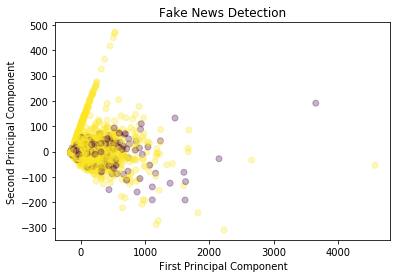

In [38]:
labels = y_out_test
df = pd.DataFrame(labels, columns = ['label'])

# perform dimensionality reduction via PCA
pca = PCA(n_components = 2)
pca_result = pca.fit_transform(X_test) # add .toarray() if X_test is sparse matrix

#source = articles_train['news_source']
#df['news_source'] = source
df['pca_one'] = pca_result[:,0]
df['pca_two'] = pca_result[:,1]

# plot figure
plt.scatter(pca_result[:,0], pca_result[:,1], alpha = 0.3, c = labels)
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title('Fake News Detection')
plt.show()

### t-SNE

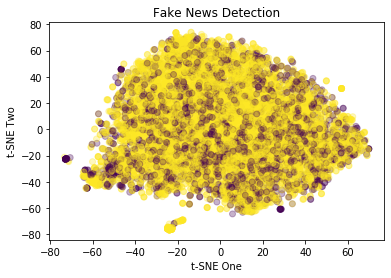

In [39]:
# select first 10K entries in X test matrix
X_test_sample = X_test[:10000,:] # add .toarray() if X_test is sparse matrix

# conduct t-SNE dimensionality reduction
tsne = TSNE(n_components = 2, metric = 'cosine')
tsne_results = tsne.fit_transform(X_test_sample)
tsne_df = pd.DataFrame()
tsne_df['tsne_one'] = tsne_results[:,0]
tsne_df['tsne_two'] = tsne_results[:,1]

# plot figure
plt.scatter(tsne_df['tsne_one'], tsne_df['tsne_two'], alpha = 0.3, c = labels[:10000])
plt.xlabel('t-SNE One')
plt.ylabel('t-SNE Two')
plt.title('Fake News Detection')
plt.show()

### UMAP

In [40]:
# to avoid unnecessary warning messages...
# taken from this thread: https://github.com/lmcinnes/umap/issues/252
import warnings
warnings.filterwarnings('ignore')

fit = umap.UMAP()
u = fit.fit_transform(X_test) # add .toarray() if X_test is sparse matrix

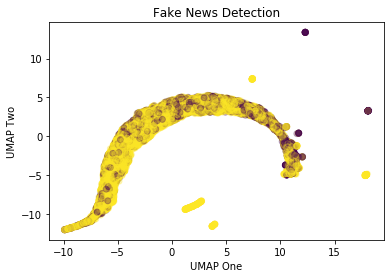

In [41]:
# plot figure
plt.scatter(u[:,0], u[:,1], alpha = 0.3, c = labels)
plt.xlabel('UMAP One')
plt.ylabel('UMAP Two')
plt.title('Fake News Detection')
plt.show()